<a href="https://colab.research.google.com/github/kondratevakate/medllm-triage-eval/blob/main/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download_data.py
import gdown

def download_drive_file(fid: str, out: str) -> str:
    """Download Drive file"""
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url, out, quiet=False)
    return out


# preprocessing.py
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Default column mapping
COLUMN_MAPPING = {
    'triage_vital_temp': 'Temperature',
    'triage_vital_hr': 'HeartRate',
    'triage_vital_rr': 'RespiratoryRate',
    'triage_vital_o2': 'Oxygen',
    'triage_vital_sbp': 'SystolicBP',
    'triage_vital_dbp': 'DiastolicBP',
    'gender': 'Sex',
    'race': 'Race',
    'esi': 'ESI'
}

def load_and_rename(path):
    """Load Feather or CSV and rename columns"""
    if path.endswith('.feather'):
        df = pd.read_feather(path)
    else:
        df = pd.read_csv(path)
    return df.rename(columns=COLUMN_MAPPING)


def impute_numeric(df, cols):
    """Median-impute numeric cols"""
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(df[c].median())
    return df


def build_features(df, numeric_cols, prefix):
    """Prepare feature matrix X and target y"""
    # Impute numeric features
    df = impute_numeric(df, numeric_cols)
    # Extract target separately
    y = pd.to_numeric(df['ESI'], errors='coerce').dropna().astype(int)
    # Build feature set
    feature_cols = numeric_cols + [col for col in df.columns if col.startswith(prefix)]
    X = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    # Align X and y indices
    X = X.loc[y.index]
    return X, y


def scale_features(X_train, X_test):
    """Standard scale features"""
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)


# model.py
from sklearn.linear_model import LogisticRegression

def get_logistic_model():
    """Logistic Regression with increased iterations"""
    return LogisticRegression(solver='lbfgs', max_iter=1000)


# evaluation.py
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    mean_squared_error, roc_auc_score
)
import numpy as np
import pandas as pd

def cv_predictions(model, X, y, n_splits=3):
    """Generate OOF preds and probs via CV"""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=cv)
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    return y_pred, y_proba


def compute_cv_metrics(y_true, y_pred, y_proba):
    """Compute CV metrics: overall, risk, safety, plus ESI-2 F1"""
    metrics = {}
    # Overall Performance
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['macro_precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['macro_recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Risk-Level Specific
    high_true = y_true.isin([1,2]).astype(int)
    high_pred = pd.Series(y_pred).isin([1,2]).astype(int)
    metrics['high_risk_recall'] = recall_score(high_true, high_pred, zero_division=0)

    # ESI-2 F1
    true2 = (y_true == 2).astype(int)
    pred2 = (pd.Series(y_pred) == 2).astype(int)
    metrics['esi2_f1'] = f1_score(true2, pred2, zero_division=0)

    moderate_true = (y_true == 3).astype(int)
    moderate_pred = (pd.Series(y_pred) == 3).astype(int)
    metrics['moderate_f1'] = f1_score(moderate_true, moderate_pred, zero_division=0)

    nonurgent_true = y_true.isin([4,5]).astype(int)
    nonurgent_pred = pd.Series(y_pred).isin([4,5]).astype(int)
    metrics['non_urgent_precision'] = precision_score(nonurgent_true, nonurgent_pred, zero_division=0)

    # Clinical Safety
    over = np.sum(y_pred < y_true)
    under = np.sum(y_pred > y_true)
    total = len(y_true)
    metrics['over_triage_rate'] = over / total
    metrics['under_triage_rate'] = under / total
    metrics['failed_predictions_count'] = int(np.sum(pd.isna(y_pred)))

    return metrics


# visualization.py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_cv_distribution(y_true, y_pred):
    """Plot true vs CV-predicted distribution"""
    true_ct = pd.Series(y_true).value_counts().sort_index()
    pred_ct = pd.Series(y_pred).value_counts().sort_index()
    all_cls = sorted(set(true_ct.index) | set(pred_ct.index))
    true_ct = true_ct.reindex(all_cls, fill_value=0)
    pred_ct = pred_ct.reindex(all_cls, fill_value=0)
    x = np.arange(len(all_cls)); w = 0.35
    fig, ax = plt.subplots(figsize=(8,5))
    ax.bar(x-w/2, true_ct, w, label='True')
    ax.bar(x+w/2, pred_ct, w, label='Pred')
    ax.set_xticks(x); ax.set_xticklabels(all_cls)
    ax.set_xlabel('ESI Level'); ax.set_ylabel('Count')
    ax.set_title('CV True vs Pred ESI'); ax.legend(); plt.show()


def report_cv_metrics(metrics):
    """Print CV metrics dict including ESI-2 F1"""
    print("Overall Performance:")
    print(f"  Accuracy:           {metrics['accuracy']:.3f}")
    print(f"  Macro Precision:    {metrics['macro_precision']:.3f}")
    print(f"  Macro Recall:       {metrics['macro_recall']:.3f}")
    print(f"  Macro F1 Score:     {metrics['macro_f1']:.3f}\n")

    print("Risk-Level Specific Metrics:")
    print(f"  High-Risk Recall:   {metrics['high_risk_recall']:.3f}")
    print(f"  ESI-2 F1:           {metrics['esi2_f1']:.3f}")
    print(f"  ESI-3 F1:        {metrics['moderate_f1']:.3f}")
    print(f"  Non-Urgent Precision: {metrics['non_urgent_precision']:.3f}\n")

    print("Clinical Safety Metrics:")
    print(f"  Over-Triage Rate:      {metrics['over_triage_rate']:.3f}")
    print(f"  Under-Triage Rate:     {metrics['under_triage_rate']:.3f}")
    print(f"  Failed Predictions:    {metrics['failed_predictions_count']}")


Downloading...
From (original): https://drive.google.com/uc?id=1wCE1Q6hXDbr1QuP7V73GEXu24l1ANnxu
From (redirected): https://drive.google.com/uc?id=1wCE1Q6hXDbr1QuP7V73GEXu24l1ANnxu&confirm=t&uuid=6cba19b4-2cfd-4936-ae37-6e1bc69e9468
To: /content/full_data.feather
100%|██████████| 278M/278M [00:02<00:00, 99.3MB/s]


Overall Performance:
  Accuracy:           0.632
  Macro Precision:    0.638
  Macro Recall:       0.451
  Macro F1 Score:     0.479

Risk-Level Specific Metrics:
  High-Risk Recall:   0.622
  ESI-2 F1:           0.648
  ESI-3 F1:        0.655
  Non-Urgent Precision: 0.738

Clinical Safety Metrics:
  Over-Triage Rate:      0.188
  Under-Triage Rate:     0.180
  Failed Predictions:    0


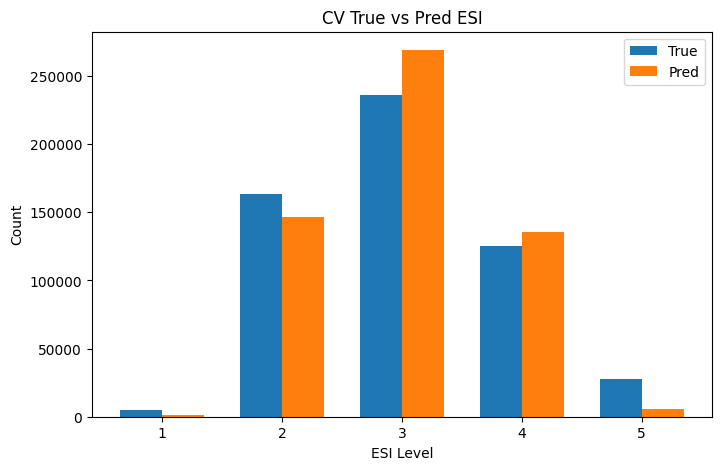

In [ ]:
# Download & load data
df_path = download_drive_file(
    "1wCE1Q6hXDbr1QuP7V73GEXu24l1ANnxu",
    "full_data.feather"
)
# load_and_rename will try feather, fallback to CSV
df = load_and_rename(df_path)

# Build and scale features
numeric_cols = ['Temperature','HeartRate','RespiratoryRate','Oxygen','SystolicBP','DiastolicBP']
X, y = build_features(df, numeric_cols, prefix='cc_')
X_scaled, _ = scale_features(X, X)

# Cross-validated predictions and metrics
model = get_logistic_model()
y_pred_cv, y_proba_cv = cv_predictions(model, X_scaled, y)
metrics = compute_cv_metrics(y, y_pred_cv, y_proba_cv)

# Reporting
report_cv_metrics(metrics)
plot_cv_distribution(y, y_pred_cv)

In [ ]:
# Build a DataFrame of true labels and predictions
cv_pred_df = pd.DataFrame({
    'true_ESI': y.values,
    'pred_ESI': y_pred_cv
}, index=y.index)

# Add predicted probabilities for each ESI class
classes = sorted(np.unique(y))
for i, cls in enumerate(classes):
    cv_pred_df[f'proba_ESI_{cls}'] = y_proba_cv[:, i]

# Save to disk
cv_pred_df.to_csv('cv_predictions.csv', index=True)
print(f"✅ Saved CV predictions: {len(cv_pred_df)} rows → 'cv_predictions.csv'")

✅ Saved CV predictions: 558029 rows → 'cv_predictions.csv'


In [ ]:
# ───── Cell: Create Random Stratified 10 000‑Row Test Set ─────
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# 1) Load & preprocess full dataset
#    (uses your existing loader & feature builder)
df_full    = load_and_rename('full_data.feather')   # or .csv
numeric_cols = ['Temperature','HeartRate','RespiratoryRate',
                'Oxygen','SystolicBP','DiastolicBP']
X_full, y_full = build_features(df_full, numeric_cols, prefix='cc_')

# 2) Stratified split for exactly 10 000 test rows
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=10000,
    random_state=42
)
train_idx, test_idx = next(sss.split(X_full, y_full))

# 3) Extract test set
X_test = X_full.iloc[test_idx]
y_test = y_full.iloc[test_idx]
df_test = df_full.iloc[test_idx].reset_index(drop=True)

# 4) Save test set to CSV (or Feather)
df_test.to_csv('random_stratified_test.csv', index=False)
print(f"Saved random_stratified_test.csv with {len(df_test)} rows")


Saved random_stratified_test.csv with 10000 rows


Overall Performance:
  Accuracy:           0.637
  Macro Precision:    0.603
  Macro Recall:       0.504
  Macro F1 Score:     0.531

Risk-Level Specific Metrics:
  High-Risk Recall:   0.625
  ESI-2 F1:           0.647
  ESI-3 F1:        0.664
  Non-Urgent Precision: 0.738

Clinical Safety Metrics:
  Over-Triage Rate:      0.177
  Under-Triage Rate:     0.186
  Failed Predictions:    0


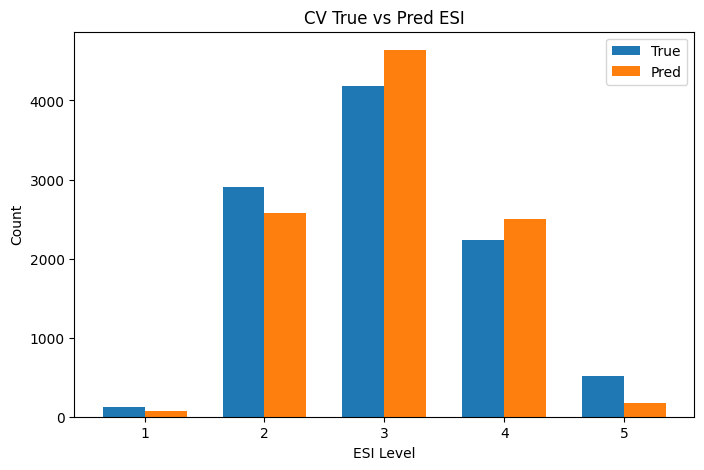

In [ ]:
# load_and_rename will try feather, fallback to CSV
df = load_and_rename('random_stratified_test.csv')

# Encode gender → integer codes (e.g. F→0, M→1)
df['Sex'] = df['Sex'].astype('category').cat.codes

# Build and scale features including Age and Sex
numeric_cols = [
    'Temperature','HeartRate','RespiratoryRate',
    'Oxygen','SystolicBP','DiastolicBP',
    'age','Sex'
]
X, y = build_features(df, numeric_cols, prefix='cc_')
X_scaled, _ = scale_features(X, X)

# Cross-validated predictions and metrics
model = get_logistic_model()
y_pred_cv, y_proba_cv = cv_predictions(model, X_scaled, y)
metrics = compute_cv_metrics(y, y_pred_cv, y_proba_cv)

# Reporting
report_cv_metrics(metrics)
plot_cv_distribution(y, y_pred_cv)

In [ ]:
fn_2 = np.sum((y == 2) & (y_pred_cv != 2) & (y_pred_cv >= 3))
fp_2 = np.sum((y_pred_cv == 2) & (y != 2) & (y >= 3))

print(f"ESI-2 missed (under-triage): {fn_2}")
print(f"ESI-2 over-triage:                        {fp_2}")

ESI-2 missed (under-triage): 1113
ESI-2 over-triage:                        749


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics_row(y_true, y_pred):
    """
    Compute triage performance metrics for a single model/run.

    Returns a dict with keys:
      'Acc.', 'P', 'R', 'F1', 'HR', 'Mod. F1', 'NP', 'OT', 'UT', 'ER'
    """
    # Overall
    acc = accuracy_score(y_true, y_pred)
    p   = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r   = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1  = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # High-risk recall (ESI 1&2)
    high_true = y_true.isin([1,2]).astype(int)
    high_pred = pd.Series(y_pred).isin([1,2]).astype(int)
    hr = recall_score(high_true, high_pred, zero_division=0)

    # Moderate (ESI-3) F1
    mod_true = (y_true == 3).astype(int)
    mod_pred = (pd.Series(y_pred) == 3).astype(int)
    mod_f1 = f1_score(mod_true, mod_pred, zero_division=0)

    # Non-urgent precision (ESI 4&5)
    non_true = y_true.isin([4,5]).astype(int)
    non_pred = pd.Series(y_pred).isin([4,5]).astype(int)
    nprec = precision_score(non_true, non_pred, zero_division=0)

    # Over- and Under-triage rates
    over = np.sum(pd.Series(y_pred) < y_true)
    under = np.sum(pd.Series(y_pred) > y_true)
    total = len(y_true)
    ot = over / total
    ut = under / total

    # Error rate
    er = 1.0 - acc

    return {
        'Acc.':     acc,
        'P':        p,
        'R':        r,
        'F1':       f1,
        'HR':       hr,
        'Mod. F1':  mod_f1,
        'NP':       nprec,
        'OT':       ot,
        'UT':       ut,
        'ER':       er
    }

metrics_row = compute_metrics_row(pd.Series(np.array(y)), pd.Series(y_pred_cv))
df_metrics = pd.DataFrame([metrics_row], index=['ExampleModel'])

df_metrics.round(2)

,Acc.,P,R,F1,HR,Mod. F1,NP,OT,UT,ER
ExampleModel,0.64,0.6,0.5,0.53,0.63,0.66,0.74,0.18,0.19,0.36
